# MNIST SGD

In [254]:
from fastai2.vision.all import *
from utils import *
matplotlib.rc('image', cmap='Blues')

## Load Images

In [255]:
im_path = untar_data(URLs.MNIST)

In [256]:
im_path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [257]:
(im_path/"training").ls()

(#10) [Path('/storage/data/mnist_png/training/0'),Path('/storage/data/mnist_png/training/2'),Path('/storage/data/mnist_png/training/9'),Path('/storage/data/mnist_png/training/8'),Path('/storage/data/mnist_png/training/7'),Path('/storage/data/mnist_png/training/1'),Path('/storage/data/mnist_png/training/5'),Path('/storage/data/mnist_png/training/4'),Path('/storage/data/mnist_png/training/6'),Path('/storage/data/mnist_png/training/3')]

In [258]:
(im_path/"training"/"3").ls()

(#6131) [Path('/storage/data/mnist_png/training/3/26208.png'),Path('/storage/data/mnist_png/training/3/12882.png'),Path('/storage/data/mnist_png/training/3/58219.png'),Path('/storage/data/mnist_png/training/3/13242.png'),Path('/storage/data/mnist_png/training/3/53225.png'),Path('/storage/data/mnist_png/training/3/51947.png'),Path('/storage/data/mnist_png/training/3/57974.png'),Path('/storage/data/mnist_png/training/3/9812.png'),Path('/storage/data/mnist_png/training/3/6658.png'),Path('/storage/data/mnist_png/training/3/11285.png')...]

In [334]:
def load_images(p):
    return torch.stack([tensor(Image.open(im)).float()/255 for im in p.ls()])

In [335]:
## Load training images
train_3s = load_images(im_path/"training"/"3")
train_8s = load_images(im_path/"training"/"7")
train_3s.shape, train_8s.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2138405b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2138f82110>)

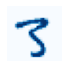

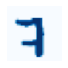

In [336]:
show_image(train_3s[0]), show_image(train_8s[0])

In [398]:
## Load validation images
valid_3s = load_images(im_path/"testing"/"3")
valid_8s = load_images(im_path/"testing"/"7")
valid_3s.shape, valid_8s.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2132f0b790>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f213850ca90>)

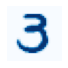

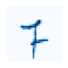

In [399]:
show_image(valid_3s[0]), show_image(valid_8s[0])

## Loss Function

For the model, we use a simple function like this:

```
pred = weights * pixels + bias
```

Basically, we assign a weight for each pixel. So, we can arrange all the pixels into a single row.

In [400]:
train_x = torch.cat([train_3s, train_8s]).view(-1, 28 * 28)
train_x.shape

torch.Size([12396, 784])

**Basically, now a single row is an image**

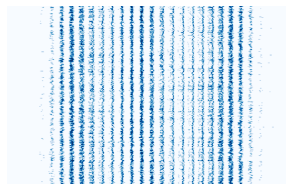

In [401]:
## How 3s looks alike
show_image(train_x[1:500,])

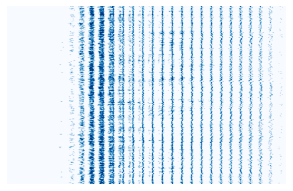

In [402]:
## How 8s looks like
show_image(train_x[-500:-1,])

**GOAL:** Find a way to differentiate these two 

In [403]:
train_y = tensor([1] * len(train_3s) + [0] * len(train_8s)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [404]:
valid_x = torch.cat([valid_3s, valid_8s]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3s) + [0] * len(valid_8s))

In [405]:
def mnist_model(X, weights, bias):
    return X@weights + bias

In [406]:
def init_params(shape):
    return torch.randn(shape).requires_grad_()

In [407]:
weights = init_params((train_x.shape[1], 1))
bias = init_params(1)        

In [408]:
preds = mnist_model(train_x, weights, bias)
preds.shape

torch.Size([12396, 1])

In [409]:
## Accuracy function
# Here we are defining the model value > 0 as 3s and others and others ans 8s.
# (This is also our loss function)
def accuracy(preds, Y):
    pred_trues = (preds > 0).float() == Y
    return pred_trues.float().mean()

In [410]:
# So, we got an accuracy of 50%
loss = accuracy(preds, train_y)
loss.item()

0.4987899363040924

In [411]:
# Now let's change the weights a bit
weights[0] *= 0.001

In [412]:
# Let's run the model again and find the loss
preds = mnist_model(train_x, weights, bias)
loss2 = accuracy(preds, train_y)
loss2.item()

0.4987899363040924

**As you can see, there's no change in our loss. So, we cannot measure the improvements of our weights using a loss function like accuracy. For that, we need something else.**

For that, we can use the abs mean error

In [413]:
## Our targets are between 0 and 1, but our preds
torch.min(preds), torch.max(preds)

(tensor(-47.8750, grad_fn=<MinBackward1>),
 tensor(9.5594, grad_fn=<MaxBackward1>))

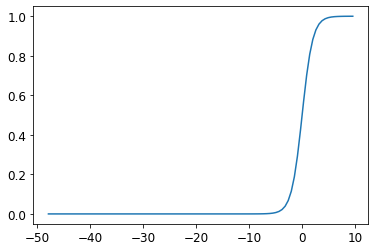

In [414]:
## So, we need some function to transform these preds into a range of 0 and 1. Luckily we have something. Sigmoid
plot_function(torch.sigmoid, min=torch.min(preds).item(), max=torch.max(preds).item())

In [415]:
def mnist_loss(preds, Y):
    return (torch.sigmoid(preds) - Y).abs().mean()

In [416]:
weights = init_params(28*28)
bias = init_params(1)     

In [417]:
preds = mnist_model(train_x, weights, bias)
loss = mnist_loss(preds, train_y)
print(f'Loss: {loss.item()}')
loss.backward()

Loss: 0.49656057357788086


In [418]:
def update_params(p, lr=1e-5):
    p.data -= p.grad * lr
    p.grad.zero_()

In [419]:
update_params(weights)
update_params(bias)

In [420]:
#run again
preds = mnist_model(train_x, weights, bias)
loss = mnist_loss(preds, train_y)
print(f'Loss: {loss.item()}')

Loss: 0.49656057357788086


**See. It's getting smaller.**

Let's put all those together.

## Using GD

In [421]:
def find_accuracy(X, Y):
    W = weights.data.clone();
    B = bias.data.clone();
    P = mnist_model(X, W, B)
    return ((torch.sigmoid(P) > 0.5) == Y).float().mean()

In [422]:
weights = init_params(28*28)
bias = init_params(1)

In [423]:
def run_epoch(lr=1.):
    preds = mnist_model(train_x, weights, bias)
    loss = mnist_loss(preds, train_y)
    loss.backward()
    update_params(weights, lr)
    update_params(bias, lr)
    
    print('ACC:', find_accuracy(valid_x, valid_y))

In [424]:
for i in range(30):
    run_epoch()

ACC: tensor(0.5481)
ACC: tensor(0.5476)
ACC: tensor(0.5476)
ACC: tensor(0.5466)
ACC: tensor(0.5471)
ACC: tensor(0.5466)
ACC: tensor(0.5471)
ACC: tensor(0.5466)
ACC: tensor(0.5461)
ACC: tensor(0.5461)
ACC: tensor(0.5461)
ACC: tensor(0.5461)
ACC: tensor(0.5461)
ACC: tensor(0.5451)
ACC: tensor(0.5451)
ACC: tensor(0.5451)
ACC: tensor(0.5442)
ACC: tensor(0.5437)
ACC: tensor(0.5432)
ACC: tensor(0.5427)
ACC: tensor(0.5427)
ACC: tensor(0.5437)
ACC: tensor(0.5437)
ACC: tensor(0.5432)
ACC: tensor(0.5437)
ACC: tensor(0.5437)
ACC: tensor(0.5432)
ACC: tensor(0.5432)
ACC: tensor(0.5427)
ACC: tensor(0.5422)


## Using SGD

In [425]:
weights = init_params(28*28)
bias = init_params(1)

In [426]:
train_dset = list(zip(train_x, train_y))

In [427]:
train_dl = DataLoader(train_dset, batch_size=256)

In [428]:
X, Y= first(train_dl)
X.shape, Y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [429]:
def run_epoch_sgd(dl, lr=1.):
    for X, Y in dl:
        preds = mnist_model(X, weights, bias)
        loss = mnist_loss(preds, Y)
        loss.backward()
        update_params(weights, lr)
        update_params(bias, lr)
        
    print('ACC', find_accuracy(valid_x, valid_y))

In [430]:
for i in range(30):
    run_epoch_sgd(train_dl, 0.7)

ACC tensor(0.6703)
ACC tensor(0.8386)
ACC tensor(0.8970)
ACC tensor(0.9156)
ACC tensor(0.9308)
ACC tensor(0.9411)
ACC tensor(0.9441)
ACC tensor(0.9470)
ACC tensor(0.9495)
ACC tensor(0.9524)
ACC tensor(0.9539)
ACC tensor(0.9553)
ACC tensor(0.9573)
ACC tensor(0.9583)
ACC tensor(0.9593)
ACC tensor(0.9598)
ACC tensor(0.9607)
ACC tensor(0.9617)
ACC tensor(0.9617)
ACC tensor(0.9617)
ACC tensor(0.9637)
ACC tensor(0.9642)
ACC tensor(0.9642)
ACC tensor(0.9647)
ACC tensor(0.9642)
ACC tensor(0.9642)
ACC tensor(0.9647)
ACC tensor(0.9647)
ACC tensor(0.9647)
ACC tensor(0.9647)


## Using FastAI + PyTorch Tools

FastAI and PyTorch comes with a lot of tools. We can reuse some of those, instead of using stuff we have defined above.

### Using Optimizer

In [431]:
model = nn.Linear(28 * 28, 1)
model

Linear(in_features=784, out_features=1, bias=True)

In [432]:
W, B = model.parameters()
W.shape, B.shape

(torch.Size([1, 784]), torch.Size([1]))

In [433]:
# Create an optimize to update params
class MyOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data -= p.grad * self.lr
            
    def zero_grad(self):
        for p in self.params:
            p.grad.zero_();

In [434]:
my_opt = MyOptim(model.parameters(), 1.)

In [435]:
## Create validation data loader
valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size=225)

In [436]:
def mnist_accuracy(preds, Y):
    return ((torch.sigmoid(preds) > 0.5) == Y).float().mean()

In [437]:
def get_accuracy(model, dl):
    acc_list = tensor([mnist_accuracy(model(X), Y) for X, Y in dl])
    return acc_list.mean()

In [438]:
def run_epoch(model, opt):
    for X, Y in train_dl:
        preds = model(X)
        loss = mnist_loss(preds, Y)
        loss.backward();
        opt.step();
        opt.zero_grad();

In [439]:
def run_model(model, epochs, lr=1.):
    opt = MyOptim(model.parameters(), lr)
    for i in range(epochs):
        run_epoch(model, opt)
        acc = get_accuracy(model, valid_dl)
        print(f'ACC: {acc.item()}')
#         opt.zero_grad();

In [440]:
run_model(model, 30, lr=0.5)

ACC: 0.5657480955123901
ACC: 0.8161777257919312
ACC: 0.8808987736701965
ACC: 0.8995062112808228
ACC: 0.9114370346069336
ACC: 0.9203161001205444
ACC: 0.9220840334892273
ACC: 0.9229728579521179
ACC: 0.9242864847183228
ACC: 0.9242864847183228
ACC: 0.9256197214126587
ACC: 0.9282863736152649
ACC: 0.928730845451355
ACC: 0.928266704082489
ACC: 0.929599940776825
ACC: 0.9304888844490051
ACC: 0.9309234619140625
ACC: 0.9318124055862427
ACC: 0.9318124055862427
ACC: 0.9318124055862427
ACC: 0.9318124055862427
ACC: 0.9318124055862427
ACC: 0.932256817817688
ACC: 0.9327012300491333
ACC: 0.9335901141166687
ACC: 0.9335901141166687
ACC: 0.9335901141166687
ACC: 0.9335901141166687
ACC: 0.9344789385795593
ACC: 0.9344789385795593


**It seems like this model is not as what we defined above**<br/>
So, let's create a custom model.

In [441]:
class MyModel:
    def __init__(self, n_features):
        self.weights = torch.randn(n_features).requires_grad_()
        self.bias = torch.randn(1).requires_grad_()
        
    def parameters(self):
        return [self.weights, self.bias]
    
    def __call__(self, X):
        return X@self.weights + self.bias

In [442]:
my_model = MyModel(28*28)
run_model(my_model, 30, lr=1.)

ACC: 0.4399999678134918
ACC: 0.447111040353775
ACC: 0.5147693157196045
ACC: 0.7031110525131226
ACC: 0.8528888821601868
ACC: 0.9133332967758179
ACC: 0.9351111650466919
ACC: 0.9502221941947937
ACC: 0.9568888545036316
ACC: 0.9608889818191528
ACC: 0.963555634021759
ACC: 0.9644444584846497
ACC: 0.9671111106872559
ACC: 0.9684444665908813
ACC: 0.9697777628898621
ACC: 0.9702222943305969
ACC: 0.9711111187934875
ACC: 0.9715555906295776
ACC: 0.9728888273239136
ACC: 0.9733333587646484
ACC: 0.9742223024368286
ACC: 0.9751111268997192
ACC: 0.9751111268997192
ACC: 0.9751111268997192
ACC: 0.9742223024368286
ACC: 0.9746667146682739
ACC: 0.9746667146682739
ACC: 0.9746667146682739
ACC: 0.9751111268997192
ACC: 0.9755555987358093


### It seems like our model is much better than nn.Linear
That's strange.